In [1]:
from importlib import reload
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [4]:
# %env TORCH_USE_CUDA_DSA 1
# %env CUDA_LAUNCH_BLOCKING 1

In [5]:
# reload(sampling_utils)
# reload(sampling)
# reload(eval_config)
# reload(model_utils)
# reload(models)
# reload(dataset_utils)
# reload(datasets)
reload(eval_config)

<module 'config.eval.countdown' from '../config/eval/countdown.py'>

In [6]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

# import config.eval.countdown as eval_config
# import config.eval.genes_base as eval_config
import config.eval.genes_hollow as eval_config

import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = eval_config.get_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)
# device = torch.device('cpu')

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data

In [30]:
data_rescaled = dataset.rescale(data.cpu()).numpy()
data_fourier = np.fft.fft(data_rescaled)

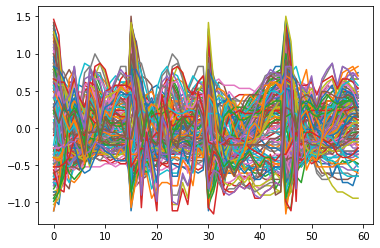

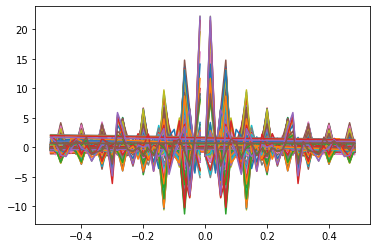

In [31]:
for i in range(156):
    plt.plot(np.arange(data.shape[1]), data_rescaled[i])
plt.figure()
for i in range(156):
    plt.plot(freq, data_fourier[i])

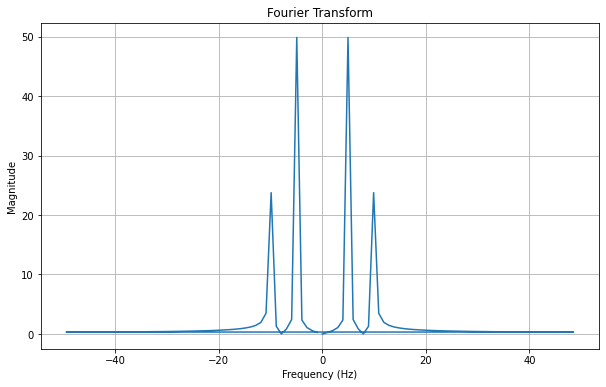

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create or load your sequence data
T = 100  # Length of the sequence
t = np.linspace(0, 1, T)
sequence = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)  # Example sequence

# Step 2: Perform the Fourier Transform
fourier_transform = np.fft.fft(sequence)

# Step 3: Calculate the frequency bins
freq = np.fft.fftfreq(T, d=t[1] - t[0])

# Step 4: Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fourier_transform))
plt.title("Fourier Transform")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


In [4]:
from eval import count_mistakes, get_dist, hellinger, eval_mse_stats

In [8]:
# def count_mistakes(samples):
#     """
#     sample: (N, L, S)
#     """
#     num_positions = samples.shape[0] * samples.shape[1]
#     return (np.sum(((samples[:,:-1] - samples[:,1:]) != 1) * (samples[:,:-1] != 0))) / num_positions

# def get_dist(seq, S):
#     L = seq.shape[0]
#     one_hot = np.zeros((L, S))
#     seq = np.array(seq, dtype=int)
#     one_hot[np.arange(L), seq] = 1
#     return np.sum(one_hot, axis=0) / L

# def hellinger(seq1, seq2, S):
#     d1, d2 = get_dist(seq1, S), get_dist(seq2, S)
#     return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

In [9]:
# from scipy.stats import skew, kurtosis

# # TODO: add autocorrelation?
# def eval_mse_stats(dataset, samples):
    
#     true_samples = dataset.data.cpu().numpy()
#     samples = np.clip(samples, 0, S-2)

#     true_samples_scaled = dataset.rescale(true_samples)
#     samples_scaled = dataset.rescale(samples)

#     out = {
#         "mean": np.mean(
#             (np.mean(samples_scaled, axis=0) 
#            - np.mean(true_samples_scaled, axis=0))**2
#         ),
#         "variance": np.mean(
#             (np.var(samples_scaled, axis=0) 
#            - np.var(true_samples_scaled, axis=0))**2
#         ),
#         "skewness": np.mean(
#             (skew(samples_scaled) 
#            - skew(true_samples_scaled))**2
#         ),
#         "kurtosis": np.mean(
#             (kurtosis(samples_scaled) 
#            - kurtosis(true_samples_scaled))**2
#         ),
#     }

#     return out

# Define and simplify the samplers

In [10]:
from lib.sampling.sampling import compute_backward, get_initial_samples

In [17]:
# Implement Gillespie's Algorithm
# The basic idea is that, each dimension has a transition holding time that we know.
# we'll just sample a holding time for each dimension, and take the smallest one to figure out the dimension of transition
# After figuring out which dimension to make the transition in, the rest is simple: 
# we simply transition to the state according to the conditional probability
from tqdm import trange, tqdm

# class PCMultiGillespies():
#     def __init__(self, cfg):
#         self.cfg =cfg

#     def sample(self, model, N, num_intermediates=0, updates_per_eval=1):
#         t = 1.0
#         D = np.prod(self.cfg.data.shape)
#         S = self.cfg.data.S
#         scfg = self.cfg.sampler
#         num_steps = scfg.num_steps
#         min_t = scfg.min_t
#         eps_ratio = scfg.eps_ratio
#         initial_dist = scfg.initial_dist
        
#         num_corrector_steps = scfg.num_corrector_steps
#         corrector_step_size_multiplier = scfg.corrector_step_size_multiplier
#         corrector_entry_time = scfg.corrector_entry_time
#         if scfg.balancing_function == "barker":
#             balancing_function = lambda score: score / (1 + score) 
#         elif scfg.balancing_function == "mpf":
#             balancing_function = lambda score: torch.sqrt(score)
#         elif scfg.balancing_function == "birthdeath":
#             balancing_function = None
#         else:
#             print("Balancing function not found: " + scfg.balancing_function)
#             return
        
#         if initial_dist == 'gaussian':
#             initial_dist_std  = model.Q_sigma
#         else:
#             initial_dist_std = None
#         device = model.device

#         # Now the batch is not syncronized anymore
#         ts = t * torch.ones((N,), device=device)
#         update_mask = ts > min_t
#         num_updates = 0
        
#         with torch.no_grad():
#             x = get_initial_samples(N, D, device, S, initial_dist,
#                 initial_dist_std)

#             x_hist = []
#             x0_hist = []
            
#             pbar = tqdm(total=D)
#             while num_updates < D:

#                 # Compute backward transition rate
#                 qt0 = model.transition(ts) # (N, S, S)
#                 rate = model.rate(ts) # (N, S, S)

#                 p0t = F.softmax(model(x, ts), dim=2) # (N, D, S)

#                 Rf, RfT, Rb, x_0max, scores = compute_backward(qt0, rate, p0t, x)
#                 # Rb: (N, D, S)
#                 Rb[torch.arange(N, device=device).repeat_interleave(D),
#                    torch.arange(D, device=device).repeat(N),
#                    x.long().flatten()] = eps_ratio
            
#                 # Compute total rate (N, D)
#                 Rb_sum = torch.sum(Rb, axis=2)
#                 # Sample a holding time (N, D)
#                 taus = torch.distributions.Exponential(Rb_sum).sample()
#                 # Find the position of the shortest holding time for each dimension (N,)
#                 ids_sorted = torch.argsort(taus, axis=1)
#                 dts = torch.zeros((N,), device=device)
                
#                 for update in range(updates_per_eval):
#                     # Make one round of updates
#                     ids = ids_sorted[:, update]
#                     # (N,)
#                     dts = taus[torch.arange(N, device=device), ids] - dts

#                     # Rates given the dimensions of transition (N, S)
#                     rates_single = Rb[torch.arange(N, device=device),ids]
#                     # Total rate given the dimensions of transition (N, 1)
#                     rates_sum_single = torch.unsqueeze(Rb_sum[torch.arange(N, device=device),ids], 1)
#                     # The targets of transition (N,)
#                     updates = torch.multinomial(rates_single / rates_sum_single, 1)[:,0]
#                     # Update ts
#                     update_mask = update_mask & ((ts - dts * update_mask) > min_t)
#                     ts -= dts * update_mask
#                     # Update x
#                     original = x[torch.arange(N, device=device), ids]
#                     x[torch.arange(N, device=device), ids] = updates * update_mask + original * (~update_mask)
#                     num_updates += 1
#                     pbar.update(1)
                    
#                 def get_rates(in_x, in_t):
#                     qt0 = model.transition(in_t) # (N, S, S)
#                     rate = model.rate(in_t) # (N, S, S)

#                     p0t = F.softmax(model(in_x, in_t), dim=2) # (N, D, S)

#                     denom_x = torch.ones_like(in_x) * (S-1)

#                     forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores = compute_backward(qt0, rate, p0t, in_x, denom_x=denom_x, eps=eps_ratio)
                    
#                     mask_positions = in_x == (S-1)
#                     nonmask_positions = ~mask_positions

#                     backward_score_to_curr = scores[
#                         torch.arange(N, device=device).repeat_interleave(D),
#                         torch.arange(D, device=device).repeat(N),
#                         in_x.long().flatten()
#                     ].view(N,D)
#                     forward_score_from_curr = 1 / (backward_score_to_curr * nonmask_positions + mask_positions)
#                     forward_score_from_curr *= nonmask_positions

#                     scores = scores * mask_positions.unsqueeze(2)
#                     scores[:,:,S-1] = forward_score_from_curr
                    
#                     forward_rates[
#                         torch.arange(N, device=device).repeat_interleave(D),
#                         torch.arange(D, device=device).repeat(N),
#                         in_x.long().flatten()
#                     ] = 0.0 
#                     reverse_rates[
#                         torch.arange(N, device=device).repeat_interleave(D),
#                         torch.arange(D, device=device).repeat(N),
#                         in_x.long().flatten()
#                     ] = 0.0 
                    
#                     return forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores
                    
#                 def take_poisson_step(in_x, in_reverse_rates, in_h):
#                     diffs = torch.arange(S, device=device).view(1,1,S) - in_x.view(N,D,1)
#                     poisson_dist = torch.distributions.poisson.Poisson(in_reverse_rates * in_h)
#                     jump_nums = poisson_dist.sample()
#                     adj_diffs = jump_nums * diffs
#                     overall_jump = torch.sum(adj_diffs, dim=2)
#                     unclip_x_new = in_x + overall_jump
#                     x_new = torch.clamp(unclip_x_new, min=0, max=S-1)

#                     return x_new

#                 if num_updates >= (1-corrector_entry_time) * D:
                    
#                     h = 1/D
                    
#                     for cstep in range(num_corrector_steps):
#                         forward_rates, transpose_forward_rates, reverse_rates, _, scores = get_rates(x, ts) # ts-h?
#                         if balancing_function is None:
#                             # We're using the default corrector
#                             # which corresponds to birth-death Stein operator
#                             corrector_rate = transpose_forward_rates + reverse_rates
#                         else:
#                             # We removed the one half here because it makes more sense for the absorbing
#                             corrector_rate = (transpose_forward_rates + forward_rates) * balancing_function(scores)
#                         # Only update dimensions with 
#                         corrector_rate *= update_mask.unsqueeze(1).unsqueeze(1)
                            
#                         corrector_rate[
#                             torch.arange(N, device=device).repeat_interleave(D),
#                             torch.arange(D, device=device).repeat(N),
#                             x.long().flatten()
#                         ] = 0.0

#                         x = take_poisson_step(x, corrector_rate, 
#                             corrector_step_size_multiplier * h)

#             p_0gt = F.softmax(model(x, min_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)
#             x_0max = torch.max(p_0gt, dim=2)[1]

#             mask_positions = x == (S-1)
#             nonmask_positions = ~mask_positions
#             samples = nonmask_positions * x + mask_positions * x_0max
            
#             out = {
#                 "ts": ts.cpu().numpy()
#             }
            
#             return samples.detach().cpu().numpy().astype(int), out

# Perform multiple sampling runs and record results

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def save_results(new_results, file_name):

    # Convert the new results to a DataFrame
    new_results_df = pd.DataFrame(new_results)

    # Check if the results file already exists
    if os.path.exists(file_name):
        # If the file exists, read the existing data
        existing_results_df = pd.read_csv(file_name)
        # Append the new results to the existing data
        updated_results_df = pd.concat([existing_results_df, new_results_df], ignore_index=True)
    else:
        # If the file does not exist, the new results are the updated results
        updated_results_df = new_results_df

    # Save the updated results to the file
    updated_results_df.to_csv(file_name, index=False)

    print("Experiment results saved to ", file_name)

In [161]:
from matplotlib.ticker import ScalarFormatter

def make_plot(file_name, metric, tag_filters=None):
    results_df = pd.read_csv(file_name)

#     tags = ['tauleaping-1', 'gillespies-1']
#     filtered_df = df[df['tag'].isin(tags)]

#     assert(False)

    if tag_filters is not None:
        results_df = results_df[results_df['tag'].isin(tags)]
    
    
    
    # Group data by method and cost
    grouped = results_df.groupby(['tag', 'nfe'])

    # Calculate mean and standard deviation for metric1
    mean_metric1 = grouped[metric].mean().unstack()
    std_metric1 = grouped[metric].std().unstack()

    
    # Plot the mean metric1 with cost on x-axis
#     plt.figure()
    fig, ax = plt.subplots(figsize=(10, 6))
    for tag in mean_metric1.index:
        print(tag)
        mean_values = mean_metric1.loc[tag].dropna()
        std_values = std_metric1.loc[tag].dropna()
         
        h = ax.plot(mean_values.index, mean_values, label=f'{tag}')[0]
        ax.scatter(mean_values.index, mean_values, s=10, color=h.get_color())
        ax.fill_between(mean_values.index, 
                         mean_values - std_values, 
                         mean_values + std_values, 
                         alpha=0.2)

    plt.xscale('log')
#     plt.yscale('log')
    plt.xlabel('NFE')
    if metric == 'h_dist':
        plt.ylabel('Hellinger Distance')
    elif metric == 'error_rate':
        plt.ylabel('Proportion of Errors')
#     plt.title('Mean Metric 1 vs Cost for Different Methods')
    plt.legend()
    plt.grid(True)
    plt.xticks([64, 128, 256, 512, 1024])
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    fig.set_facecolor("white")
    ax.set_facecolor("white")
    plt.show()

In [124]:

# Define a function to create tags based on the method and c_steps
def create_tag(row):
    return f"{row['method']}-{row['c_steps']}-{row['corrector']}-{row['c_stepsize']}"

def update_tags(file_name):
    # Read the existing data
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
    else:
        raise FileNotFoundError(f"{file_name} does not exist.")

    

    # Apply the tag function to each row
    df['tag'] = df.apply(create_tag, axis=1)

    # Save the updated data back to the CSV file
    df.to_csv(file_name, index=False)

    print("Tags added and results saved to", file_name)
    


In [216]:
method

'gillespies'

In [367]:
tqdm._instances.clear()

results_file = 'countdown_results_fixed.csv'

num_repeats = 3

sample_size = 100
method = "gillespies"
# method = "tauleaping"

# Gillespies only
updates_per_eval = 1
# Tau-leaping only
eval_cfg.sampler.num_steps = 200

# Generic corrector fields
eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = 2.
eval_cfg.sampler.balancing_function = "mpf"

if method == "gillespies":
    eval_cfg.sampler.name = "PCMultiGillespies"
#     sampler = PCMultiGillespies(eval_cfg)
elif method == "tauleaping":
    eval_cfg.sampler.name = "PCTauLeapingAbsorbingInformed"
else:
    assert(False)

sampler = sampling_utils.get_sampler(eval_cfg)
    
results = []

for _ in range(num_repeats):
    if method == "gillespies":
        samples, out = sampler.sample(model, sample_size, updates_per_eval=updates_per_eval)
    elif method == "tauleaping":
        samples, out = sampler.sample(model, sample_size, 0)

    data_flat = dataset.data.flatten().cpu().numpy()
    h_dist = hellinger(data_flat, samples.flatten(), eval_cfg.data.S)
    error_rate = count_mistakes(samples)

    D = eval_cfg.data.shape[0]
    if method == "gillespies":
        nfe = D / updates_per_eval
    elif method == "tauleaping":
        nfe = eval_cfg.sampler.num_steps
    nfe += nfe * eval_cfg.sampler.corrector_entry_time * eval_cfg.sampler.num_corrector_steps

    new_result = {
                'method': method,
                'g_steps': 0 if method != "gillespies" else updates_per_eval,
                'tau_steps': 0 if method != "tauleaping" else eval_cfg.sampler.num_steps,
                'use_corrector': eval_cfg.sampler.corrector_entry_time > 0 
                             and eval_cfg.sampler.num_corrector_steps > 0,
                'corrector': eval_cfg.sampler.balancing_function,
                'c_stepsize': eval_cfg.sampler.corrector_step_size_multiplier,
                'c_steps': eval_cfg.sampler.num_corrector_steps,
                'nfe': nfe,
                'h_dist': h_dist,
                'error_rate': error_rate,
            }
    print(new_result)
    results.append(new_result)
    
save_results(results, results_file)
update_tags(results_file)

100%|██████████| 256/256 [00:25<00:00, 10.19it/s]


{'method': 'gillespies', 'g_steps': 1, 'tau_steps': 0, 'use_corrector': True, 'corrector': 'mpf', 'c_stepsize': 2.0, 'c_steps': 1, 'nfe': 486.4, 'h_dist': 0.04693287602723913, 'error_rate': 0.0011328125}


100%|██████████| 256/256 [00:25<00:00, 10.18it/s]


{'method': 'gillespies', 'g_steps': 1, 'tau_steps': 0, 'use_corrector': True, 'corrector': 'mpf', 'c_stepsize': 2.0, 'c_steps': 1, 'nfe': 486.4, 'h_dist': 0.049261120848757126, 'error_rate': 0.00109375}


100%|██████████| 256/256 [00:25<00:00, 10.20it/s]


{'method': 'gillespies', 'g_steps': 1, 'tau_steps': 0, 'use_corrector': True, 'corrector': 'mpf', 'c_stepsize': 2.0, 'c_steps': 1, 'nfe': 486.4, 'h_dist': 0.0447853136779277, 'error_rate': 0.0011328125}
Experiment results saved to  countdown_results_fixed.csv
Tags added and results saved to countdown_results_fixed.csv


In [376]:
# tags = [
#     "gillespies-1-birthdeath-0.1",
#     "gillespies-2-birthdeath-0.1",
#     "tauleaping-1-birthdeath-0.1",
#     "tauleaping-2-birthdeath-0.1"
# ]
tags = [
#     "gillespies-1-mpf-0.1", "gillespies-2-mpf-0.1",
#         "gillespies-1-mpf-1.0", "gillespies-2-mpf-1.0",
    "gillespies-1-mpf-2.0", "gillespies-2-mpf-2.0",
#     "tauleaping-1-mpf-0.1", "tauleaping-2-mpf-0.1",
#     "tauleaping-1-mpf-1.0", "tauleaping-2-mpf-1.0",
    "tauleaping-1-mpf-2.0", "tauleaping-2-mpf-2.0"
]
# tags = [
#     "gillespies-1-barker-1.0", "gillespies-2-barker-1.0",
#     "tauleaping-1-barker-1.0", "tauleaping-2-barker-1.0"
# ]
# tags = None
print(sampler)

Tags added and results saved to countdown_results_fixed.csv
gillespies-1-mpf-2.0
gillespies-2-mpf-2.0
tauleaping-1-mpf-2.0
tauleaping-2-mpf-2.0


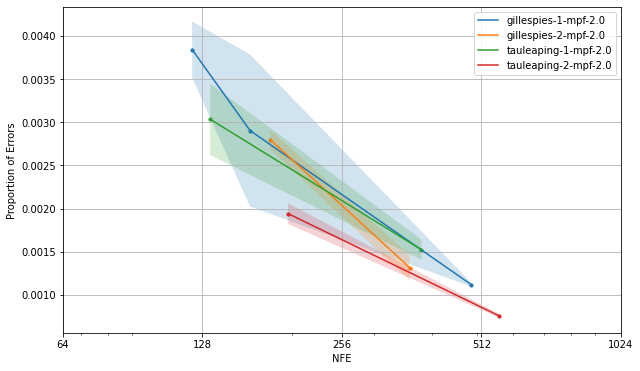

gillespies-1-mpf-2.0
gillespies-2-mpf-2.0
tauleaping-1-mpf-2.0
tauleaping-2-mpf-2.0


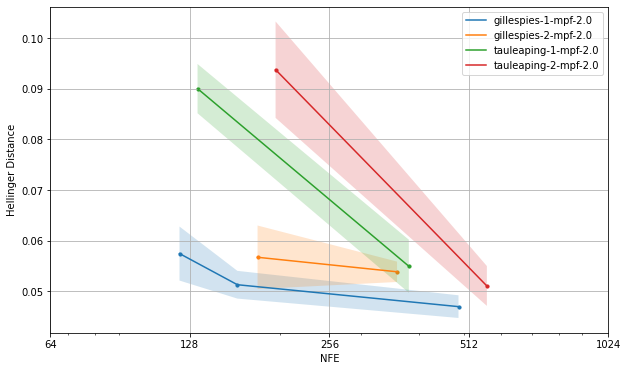

In [377]:
update_tags(results_file)
make_plot(results_file, 'error_rate', tag_filters=tags)
make_plot(results_file, 'h_dist', tag_filters=tags)

In [325]:
# existing_results_df = pd.read_csv("countdown_results_test.csv")
# existing_results_df = existing_results_df[existing_results_df["method"]=="gillespies"]
# fixed_results_df = pd.read_csv(results_file)
# updated_results_df = pd.concat([existing_results_df, fixed_results_df], ignore_index=True)
# updated_results_df.to_csv(results_file, index=False)

In [268]:
eval_cfg.data

S: 33
batch_size: 64
data_size: 6400
name: Countdown
shape:
- 256
shuffle: true

In [258]:
id = 0

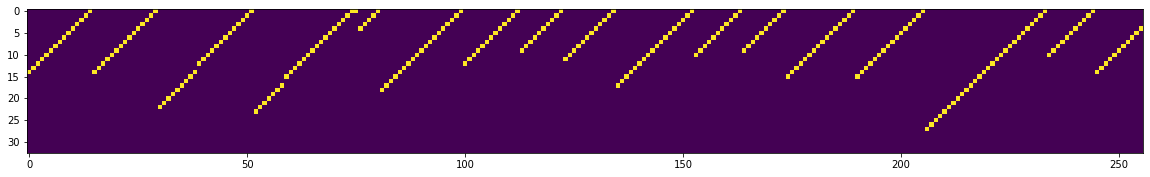

In [137]:
id += 1
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(samples[id]), S).T)

In [128]:
print(count_mistakes(samples))

0.0056640625


In [129]:
data_flat = dataset.data.flatten().cpu().numpy()
samples_flat = samples.flatten()

In [130]:
def get_dist(seq, S):
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return np.sum(one_hot, axis=0) / L

def hellinger(seq1, seq2, S):
    d1, d2 = get_dist(seq1, S), get_dist(seq2, S)
    return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

hellinger(data_flat, samples_flat, eval_cfg.data.S)

0.027636434019605142

# Take the samples

In [10]:
num_samples = 100
eval_cfg.sampler.name = 'PCTauLeapingAbsorbingInformed'
eval_cfg.sampler.corrector_step_size_multiplier = 2.
eval_cfg.sampler.balancing_function = "mpf"
sampler = sampling_utils.get_sampler(eval_cfg)
print(sampler)
samples, hist = sampler.sample(model, num_samples, 500,)

499it [01:14,  6.69it/s]


In [11]:
x_hist = hist["x"]
x0_hist = hist["x0"]
c_rate_hist = hist["rc"]

In [12]:
# patch: process the samples by combining model prediction and current location
print(count_mistakes(samples))
is_mask = x_hist[-1] == (S-1)
corrected_samples = is_mask * samples + (1 - is_mask) * x_hist[-1]
print(count_mistakes(corrected_samples))

0.0005078125
0.0005078125


In [15]:
eval_cfg.sampler

balancing_function: mpf
corrector_entry_time: 0.9
corrector_step_size_multiplier: 2.0
eps_ratio: 1.0e-09
initial_dist: absorbing
min_t: 0.01
name: PCTauLeapingAbsorbingInformed
num_corrector_steps: 2
num_steps: 500
reject_multiple_jumps: true

In [20]:
data_flat = dataset.data.flatten().cpu().numpy()
# samples_flat = corrected_samples.flatten()
hellinger(data_flat, samples_flat, eval_cfg.data.S-1)

0.04670345126994198

# Examine the samples

In [21]:
eval_cfg.sampler.corrector_step_size_multiplier

2.0

In [22]:
x_hist = hist["x"]
x0_hist = hist["x0"]
c_rate_hist = hist["rc"]

In [24]:
# np.sum(((samples[id,:-1] - samples[id,1:]) != 1) * (samples[id,:-1] != 0))

In [25]:
l = -1
id = -1

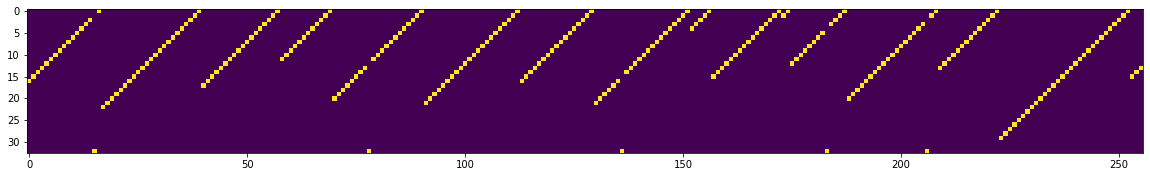

In [27]:
id += 1
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(x_hist[-1, id]), S).T)

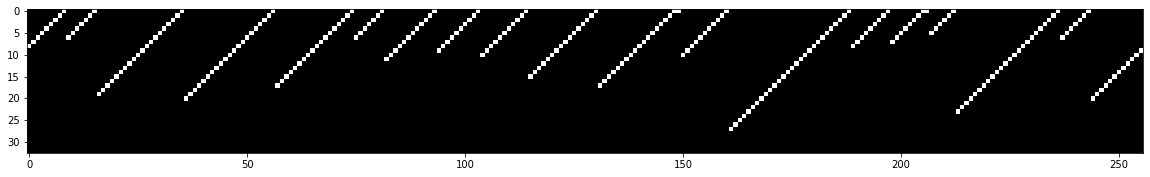

In [40]:
id += 1
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
visualize_diff(ax1, samples[id], corrected_samples[id])

In [41]:
l = 50

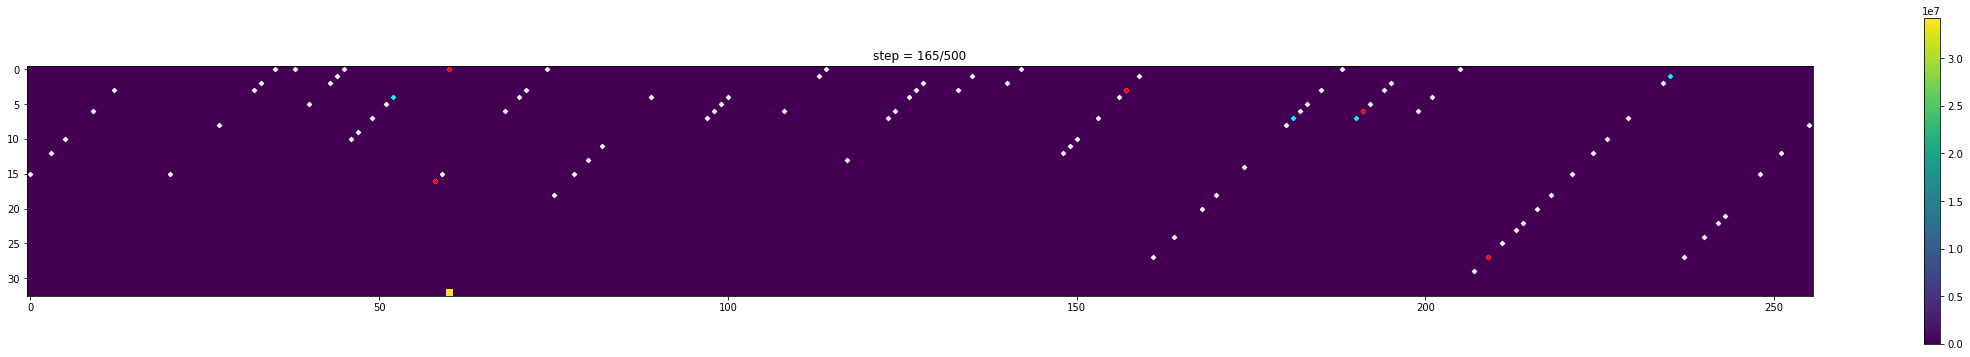

In [92]:
l += 1

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(40, 6))
# visualize_diff(ax1, x_hist[l, id], x_hist[l+1, id])
ax2.set_title("step = {}/{}".format(l, eval_cfg.sampler.num_steps))
cr = c_rate_hist[l, id].T
# one_hot = F.one_hot(torch.tensor(x_hist[l, id]), S).T.cpu().numpy()
cat = ax2.imshow(cr, vmin=cr.min(), vmax=cr.max())

x = x_hist[l, id]
y = x_hist[l+1, id]
diff_loc = x != y

scale = (S-1) / eval_cfg.sampler.corrector_step_size_multiplier / 500
# ax2.plot(S - 1 - cr[-1,:] * scale, color='c', alpha=.4)
ax2.scatter(np.arange(cr.shape[1])[x<S-1], x[x<S-1], color="w", marker="D", s=10)
ax2.scatter((np.arange(cr.shape[1]))[diff_loc * (x<S-1)], x[diff_loc * (x<S-1)], color="r", marker="D", s=10)
ax2.scatter((np.arange(cr.shape[1]))[diff_loc * (y<S-1)], y[diff_loc * (y<S-1)], color="cyan", marker="D", s=10)
fig.colorbar(cat, ax=ax2)
fig.set_facecolor('white')

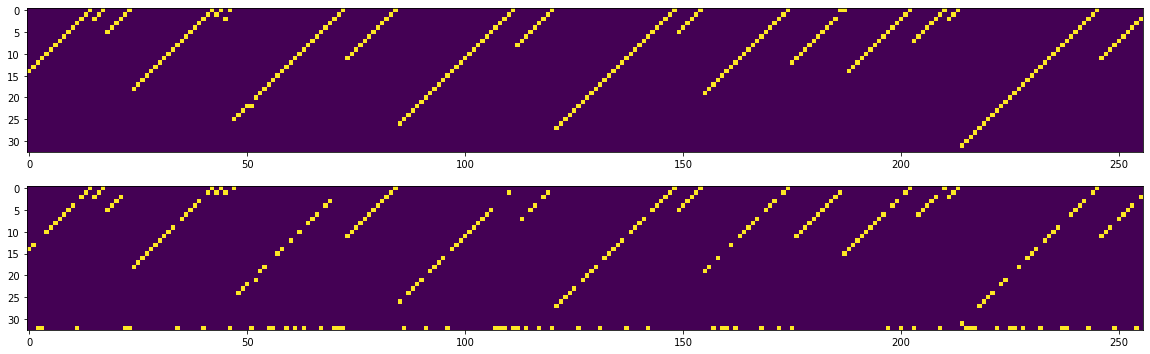

In [447]:
l -= 1
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))

# Plotting on the first axis
ax1.imshow(F.one_hot(torch.tensor(x0_hist[l, id]), S).T)
ax2.imshow(F.one_hot(torch.tensor(x_hist[l, id])).T)

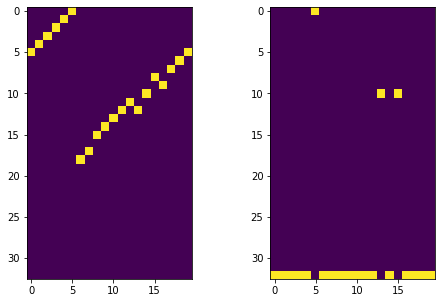

In [194]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

# Plotting on the first axis
ax1.imshow(F.one_hot(torch.tensor(x0_hist[id, 0, 80:100]), S).T)
ax2.imshow(F.one_hot(torch.tensor(x_hist[id, 0, 80:100])).T)
fig.set_facecolor('white')

# Evaluate real sequence datasets

In [52]:
tqdm._instances.clear()

num_samples = 500
updates_per_eval = 5
eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.name = "PCMultiGillespies"
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .1
eval_cfg.sampler.balancing_function = "mpf"
sampler = sample_utils.(eval_cfg)

num_repeats = 20

total_results = None
for _ in range(num_repeats):
    samples, ts = sampler.sample(model, num_samples, 0, updates_per_eval=updates_per_eval)
    samples = np.clip(samples, 0, S-2)
    out_dict = eval_mse_stats(dataset, samples)
    if total_results is None:
        total_results = {key: [out_dict[key]] for key in out_dict}
    else:
        for key, value in out_dict.items():
            total_results[key].append(value)
            
metrics = ["Mean", "Variance", "Skewness", "Kurtosis"]
for metric in metrics:
    results = total_results[metric.lower()]
    print(metric + ": {:.1e} pm {:.1e}".format(np.mean(results), np.std(results)))

100%|██████████| 60/60 [00:00<00:00, 62.81it/s]

Mean: 1.0e-03 pm 3.4e-04
Variance: 3.9e-04 pm 1.2e-04
Skewness: 3.1e-02 pm 8.2e-03
Kurtosis: 1.9e-01 pm 9.7e-02


In [ ]:
# Gene - hollow - 1Gillespies
# Mean: 1.1e-03 pm 4.2e-04
# Variance: 2.1e-04 pm 1.1e-04
# Skewness: 2.8e-02 pm 8.1e-03
# Kurtosis: 2.1e-01 pm 8.0e-02
# pretty much identical with 2g1mpf

In [ ]:
# Gene - hollow - 3Gillespies1mpf(rate=.5)
# Mean: 1.7e-03 pm 8.1e-04
# Variance: 2.9e-04 pm 1.6e-04
# Skewness: 4.1e-02 pm 1.1e-02
# Kurtosis: 1.5e-01 pm 4.3e-02
# Worse.

In [ ]:
# Gene - hollow - 3Gillespies1mpf(rate=.1)
# Mean: 9.3e-04 pm 3.9e-04
# Variance: 1.7e-04 pm 5.8e-05
# Skewness: 2.8e-02 pm 9.3e-03
# Kurtosis: 1.6e-01 pm 1.2e-01
# Pretty much identical lol

In [ ]:
# Gene - hollow - 2Gillespies1mpf
# Mean: 1.1e-03 pm 4.8e-04
# Variance: 1.7e-04 pm 5.4e-05
# Skewness: 3.2e-02 pm 8.4e-03
# Kurtosis: 1.8e-01 pm 9.8e-02
# We're taking 20 samples above this line
# ----------------------------------------

In [ ]:
# Gene - hollow - 2Gillespies1mpf(rate=1)
# Bad.

In [ ]:
# Gene - hollow - 2Gillespies1Barker(rate=1)
# Mean: 1.1e-03 pm 4.2e-04
# Variance: 1.0e-04 pm 3.6e-05
# Skewness: 5.3e-02 pm 1.8e-02
# Kurtosis: 4.2e-01 pm 6.6e-02
# Not much improvment... but less evaluations is good!

In [ ]:
# Gene - hollow - 3Gillespies
# Mean: 7.6e-04 pm 2.1e-04
# Variance: 1.6e-04 pm 4.0e-05
# Skewness: 2.5e-02 pm 4.4e-03
# Kurtosis: 1.7e-01 pm 6.6e-02
# Huh???

In [ ]:
# Gene - hollow - 3Gillespies1mpf
# Mean: 8.2e-04 pm 2.8e-04
# Variance: 2.0e-04 pm 7.2e-05
# Skewness: 2.8e-02 pm 6.5e-03
# Kurtosis: 1.9e-01 pm 9.0e-02
# Not much improvment... but less evaluations is good!

In [ ]:
# Gene - hollow - 1Gillespies
# Mean: 1.0e-03 pm 3.8e-04
# Variance: 1.9e-04 pm 8.8e-05
# Skewness: 2.7e-02 pm 6.6e-03
# Kurtosis: 1.8e-01 pm 9.0e-02
# Mean: 1.3e-03 pm 7.4e-04
# Variance: 2.3e-04 pm 1.3e-04
# Skewness: 3.0e-02 pm 1.2e-02
# Kurtosis: 2.6e-01 pm 1.1e-01
# Somehow this is already better??

In [ ]:
# Gene - baseline - 1Gillespies
# Mean: 1.3e-02 pm 4.1e-04
# Variance: 1.3e-02 pm 2.4e-04
# Skewness: 3.3e-01 pm 1.9e-02
# Kurtosis: 1.1e+00 pm 1.0e-01
# This is pretty bad.